In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import LowRankRNN
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal

/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
EPS = 1e-16

# multivariate normal initialization variance
sigma_init = 1.0
#sigma_init = 3.16
c_init_order = 15

dirstr = 'LowRankRNN'

# create an instance of the LowRankRNN system class
fixed_params = {'g':0.2, 'betam':0.6, 'betan':1.0}

behavior_type = "CDD"
means = np.array([0.3, 0.3])
variances = np.array([0.001, 0.001])
    
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':2, 'input_type':'input'}

solve_its = 100
solve_eps = 0.2

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)


# normalizing flow layer architecture
TIF_flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'D':system.D, \
             'latent_dynamics':None, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers}

lr_order = -3

ind  0 behavior checked
ind  1 behavior checked
ind  2 behavior checked
ind  3 behavior checked
ind  4 behavior checked


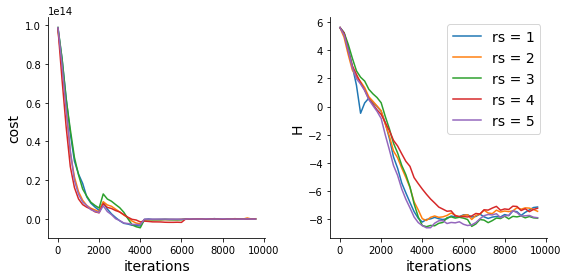

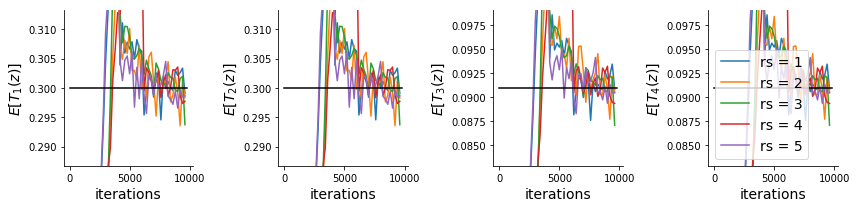

p values
0
1
2
3
4


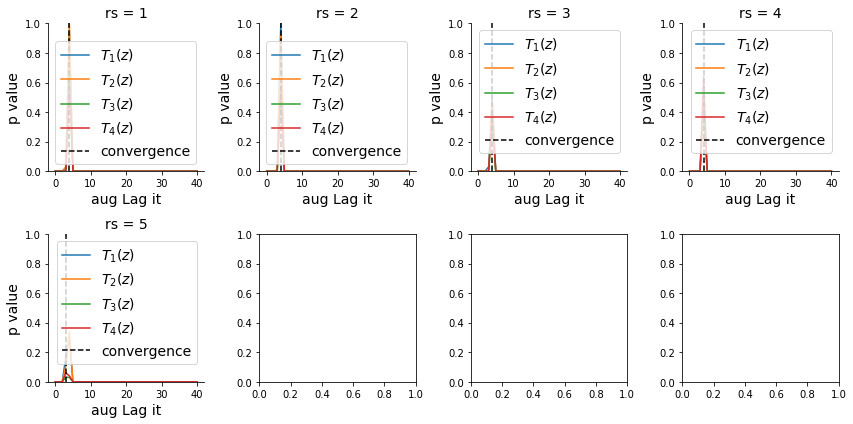

In [11]:
start_rs = 1
num_rs = 5

random_seeds = np.arange(start_rs, num_rs+start_rs)


basedir = '/Users/sbittner/Documents/dsn/dsn/'
fnames = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    fnames.append(fname)
    legendstrs.append('rs = %d' % random_seed)
    npzfile = np.load(fname)
    behavior_i = npzfile['behavior'][()]
    assert(approx_equal(behavior_i['means'], behavior['means'], EPS))
    assert(approx_equal(behavior_i['variances'], behavior['variances'], EPS))
    print('ind ', i, 'behavior checked')
    
figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, con_method='1', frac_samps=0.2)

 has not converged so not plotting.


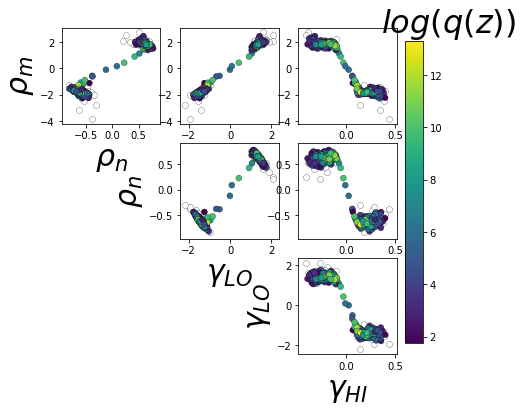

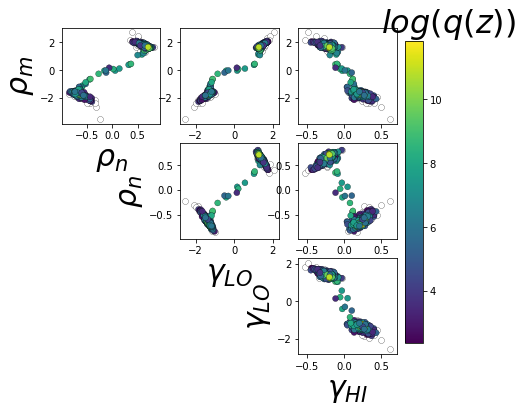

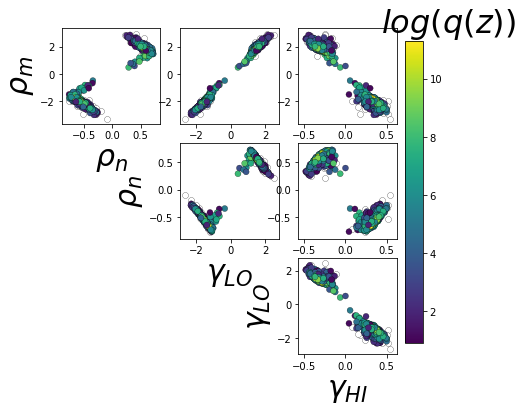

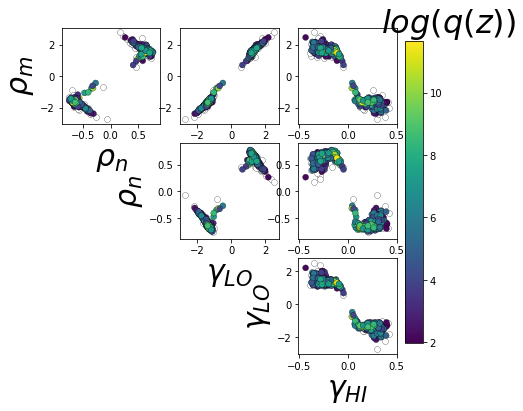

[array([[ 1.95442549,  0.57619296,  1.54275138, -0.16007631],
        [-1.94740564, -0.51162623, -1.66030071,  0.16457967],
        [ 1.70208498,  0.68988243,  1.19424548, -0.30294716],
        ...,
        [-1.617079  , -0.58748818, -1.32846377,  0.29216087],
        [-1.76996398, -0.67165052, -1.2428941 ,  0.31692494],
        [ 1.79507726,  0.64564961,  1.35894755, -0.25390873]]),
 array([[-1.90559617, -0.58604313, -1.47981013,  0.16952961],
        [ 1.78406876,  0.60405701,  1.45091359, -0.24113533],
        [-1.69449805, -0.6683463 , -1.29519074,  0.26511395],
        ...,
        [-1.83657793, -0.56410589, -1.490507  ,  0.27208587],
        [-1.57029278, -0.72994432, -1.17423862,  0.2085169 ],
        [ 1.65431651,  0.70209106,  1.28502841, -0.19525009]]),
 array([[-2.52501675, -0.37171037, -1.96338626,  0.46118794],
        [ 2.24575262,  0.37280045,  1.90894137, -0.36285415],
        [ 2.07177338,  0.52781069,  1.62815599, -0.26689103],
        ...,
        [-2.03476157, -0.64

In [9]:
pfname = 'images/rank1_ND_DSN_Z.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
              fontsize=30, ellipses=False, tri=True, pfname=pfname)

In [5]:
AL_final_it = AL_final_its[0]
fname = fnames[0]
npzfile = np.load(fname)
Zs = npzfile['Zs'][AL_final_it]
T_xs = npzfile['T_xs'][AL_final_it]

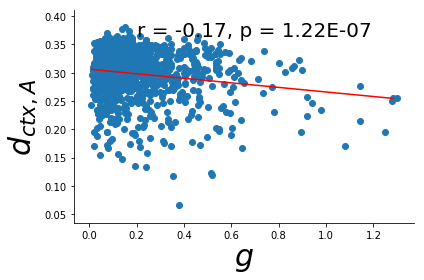

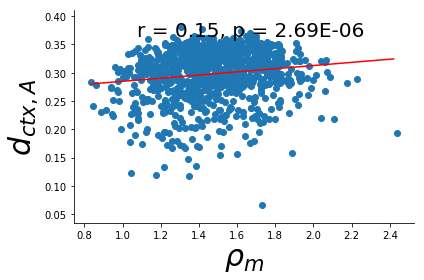

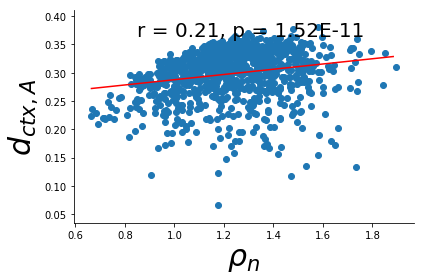

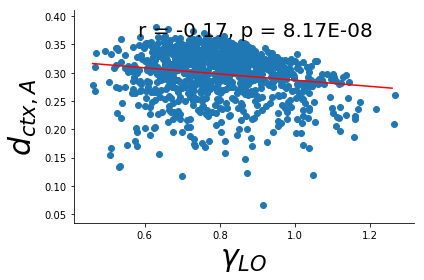

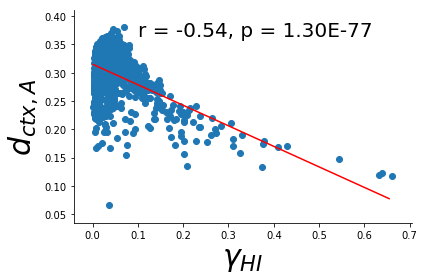

In [10]:
fontsize = 30
    
z_inds = [0,1,2,3,4]
T_inds = [0,0,0,0,0]
num_inds = len(z_inds)
for i in range(num_inds):
    z_ind = z_inds[i]
    T_ind = T_inds[i]
    lin_reg_plot(Zs[:,z_ind], T_xs[:,T_ind], system.z_labels[z_ind], system.T_x_labels[T_ind], \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)

In [17]:
from dsn.util.tf_DMFT_solvers import rank2_CDD_chaotic_solve

DTYPE = tf.float64
num_conds = 4
M = Zs.shape[0]
c_LO = 0.0
c_HI = 1.0

Z_tf = tf.placeholder(dtype=DTYPE, shape=Zs.shape)

g = tf.tile(Z_tf[:,0], [4])
rhom = tf.tile(Z_tf[:,1], [4])
rhon = tf.tile(Z_tf[:,2], [4])
gammaLO = tf.tile(-Z_tf[:,3], [2])
gammaHI = tf.tile(Z_tf[:,4], [2])

gammaA = tf.concat((gammaHI, gammaLO), axis=0)
gammaB = tf.concat((gammaLO, gammaHI), axis=0)

cA = tf.concat((c_HI*tf.ones((M,), dtype=DTYPE), 
                 c_LO*tf.ones((M,), dtype=DTYPE),
                 c_HI*tf.ones((M,), dtype=DTYPE), 
                 c_LO*tf.ones((M,), dtype=DTYPE)), 
                 axis=0)
cB = tf.concat((c_LO*tf.ones((M,), dtype=DTYPE), 
                 c_HI*tf.ones((M,), dtype=DTYPE),
                 c_LO*tf.ones((M,), dtype=DTYPE), 
                 c_HI*tf.ones((M,), dtype=DTYPE)), 
                 axis=0)

kappa1_init = -5.0 * tf.ones((num_conds*M,), dtype=DTYPE)
kappa2_init = -5.0 * tf.ones((num_conds*M,), dtype=DTYPE)
delta_0_init = 5.0 * tf.ones((num_conds*M,), dtype=DTYPE)
delta_inf_init = 4.0 * tf.ones((num_conds*M,), dtype=DTYPE)

betam = 0.6*tf.ones((num_conds*M,), dtype=DTYPE)
betan = tf.ones((num_conds*M,), dtype=DTYPE)

solve_its = 25
eps = 0.5

kappa1, kappa2, delta_0, delta_inf, z, xs = rank2_CDD_chaotic_solve(
                kappa1_init,
                kappa2_init,
                delta_0_init,
                delta_inf_init,
                cA,
                cB,
                g,
                rhom,
                rhon,
                betam,
                betan,
                gammaA,
                gammaB,
                solve_its,
                eps,
                gauss_quad_pts=50,
                db=True,
            )

In [18]:
with tf.Session() as sess:
    _kappa1, _kappa2, _delta_0, _delta_inf, _z, _xs = sess.run([kappa1, kappa2, delta_0, delta_inf, z, xs], {Z_tf:Zs})

_delta_T = _delta_0 - _delta_inf

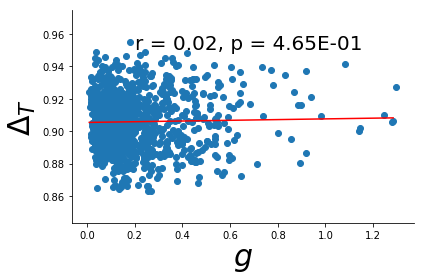

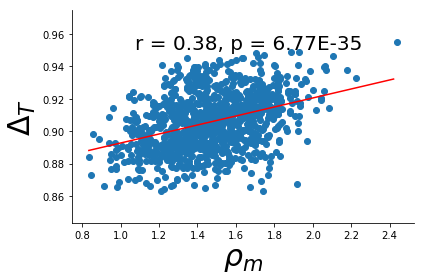

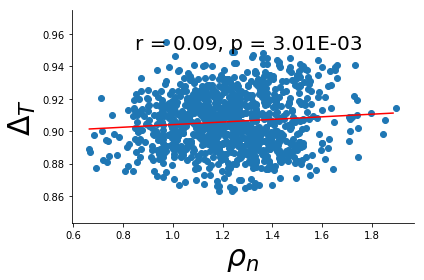

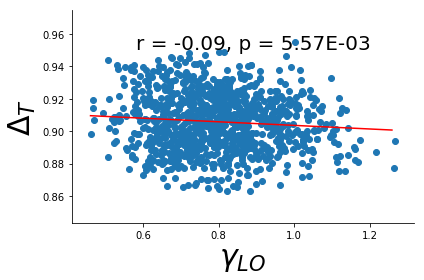

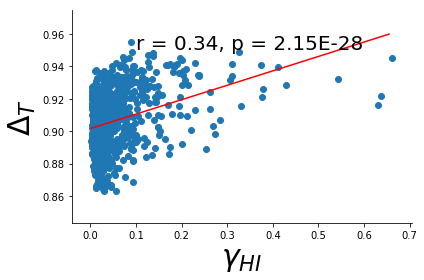

In [22]:
for i in range(system.D):
    _delta_T_avg = (_delta_T[:M] + _delta_T[M:2*M] + _delta_T[2*M:3*M] + _delta_T[3*M:4*M]) / 4
    lin_reg_plot(Zs[:,i], _delta_T_avg, system.z_labels[i], r'$\Delta_T$', \
                     pfname='images/corr%d' % (i+1), fontsize=fontsize)